In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pynoisy
import xarray as xr
import time, os
from tqdm.notebook import tqdm
import metric_utils

## Load eigenvectors
---

In [3]:
path = '../../eigenvectors/wind_angle_modes.advection_angle.yaml.LOBPCGiter50_degree24_precond_False_64x64x64.nc'
eigenvectors = xr.load_dataset(path)

In [14]:
wind_angle_true = 0.805

hyperparams = {
    'nt': int(eigenvectors.nt.data),
    'nx': int(eigenvectors.nx.data),
    'ny': int(eigenvectors.ny.data),
    'wind_angle': wind_angle_true,
    'wind_magnitude': eigenvectors.wind_magnitude.data,
    'correlation_time': eigenvectors.correlation_time.data,
    'correlation_length': eigenvectors.correlation_length.data,
    'evolution_length': eigenvectors.evolution_length.data,
    'spatial_angle': eigenvectors.spatial_angle.data,
    'tensor_ratio': eigenvectors.tensor_ratio.data}
solver = pynoisy.forward.HGRFSolver.homogeneous(**hyperparams)
solver.reseed(18875)
measurements = solver.run(num_frames=hyperparams['nt'], n_jobs=4, evolution_length=hyperparams['evolution_length'])

<IPython.core.display.Javascript object>


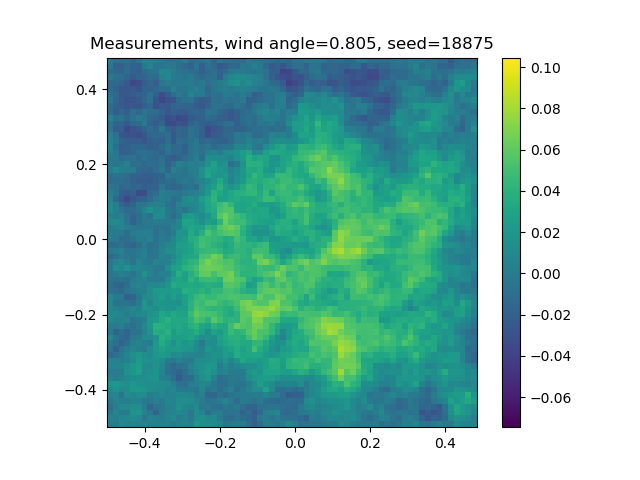

In [9]:
%matplotlib notebook
animation = humidity.noisy_methods.get_animation(cmap='viridis')
plt.title('Measurements, wind angle={:1.3}, seed={}'.format(wind_angle_true, humidity.seed))
animation.save('./gifs/meas_windangle_{:1.3}_seed{}.gif'.format(wind_angle_true, humidity.seed), writer='imagemagick')

## Metric comparison
---

In [21]:
"""
Compute likelihood metrics for eigenvector projection
"""
measurements = humidity.copy()
degrees = [4, 8, 16, 24]
lobpcg_proj_precond = xr.concat([metric_utils.projection_residual(measurements, eigenvectors_precond.eigenvectors, deg) for deg in degrees], dim='deg')

In [43]:
np.allclose(eigenvectors.eigenvectors.data, eigenvectors_precond.eigenvectors.data)

True

In [22]:
"""
Compute likelihood metrics for eigenvector projection
"""
measurements = humidity.copy()
degrees = [4, 8, 16, 24]
lobpcg_proj = xr.concat([metric_utils.projection_residual(measurements, eigenvectors.eigenvectors, deg) for deg in degrees], dim='deg')

<IPython.core.display.Javascript object>


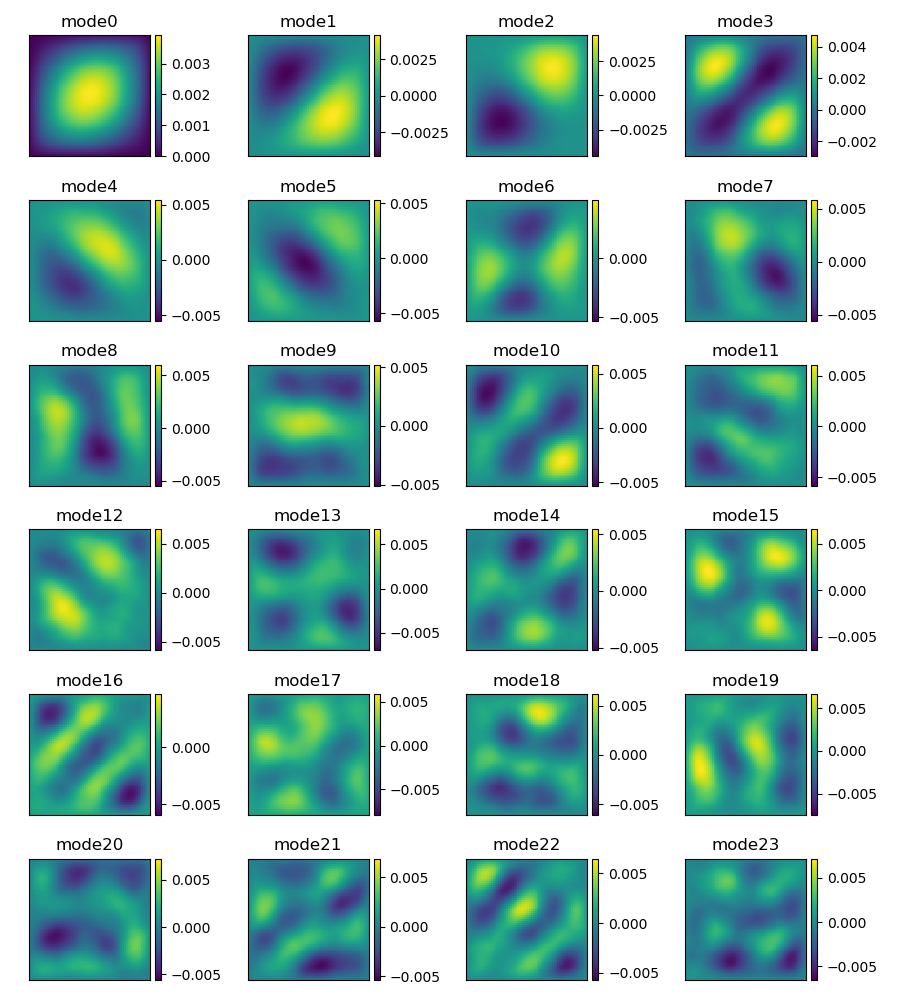

In [35]:
%matplotlib notebook
animation_degree = 24

fig, axes = plt.subplots(int(animation_degree/4),4, figsize=(9,10))
animation = pynoisy.utils.multiple_animations(
    eigenvectors_precond.eigenvectors.sel(wind_angle=wind_angle_true, deg=range(animation_degree), method='nearest'), 
    axes.ravel(), cmaps='viridis', titles=['mode{}'.format(deg) for deg in range(animation_degree)])

<IPython.core.display.Javascript object>


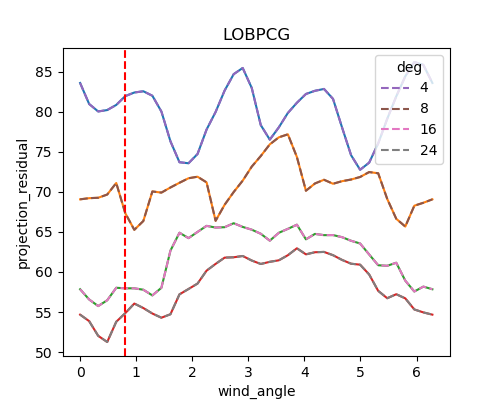

Text(0.5, 1.0, 'LOBPCG')

In [38]:
%matplotlib notebook 
degrees = [4, 8, 16, 24] 
fig, ax = plt.subplots(1, 1, figsize=(5,4))
lobpcg_proj_precond.sel(deg=degrees).plot(ax=ax, hue='deg')
lobpcg_proj.sel(deg=degrees).plot(ax=ax, hue='deg', linestyle='--')
ax.axvline(wind_angle_true, linestyle='--', color='r')
ax.set_title('LOBPCG')

<IPython.core.display.Javascript object>


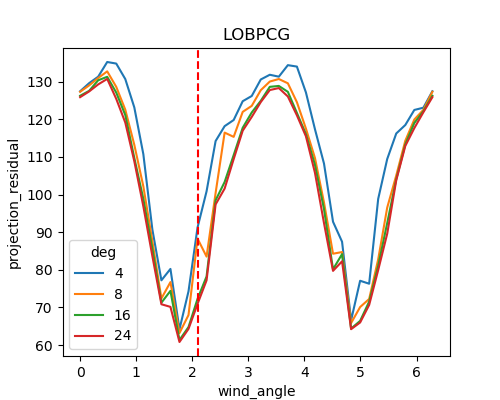

Text(0.5, 1.0, 'LOBPCG')

In [74]:
%matplotlib notebook 
degrees = [4, 8, 16, 24] 
fig, ax = plt.subplots(1, 1, figsize=(5,4))
(metrics.projection_residual).sel(deg=degrees).plot(ax=ax, hue='deg')
ax.axvline(wind_angle_true, linestyle='--', color='r')
ax.set_title('LOBPCG')

In [65]:
coords = {'wind_angle': eigenvectors.wind_angle.data}
krylov_residual = metric_utils.compute_krylov_loss(measurements, hyperparams, coords, degrees)
metrics = xr.merge([metrics, krylov_residual])

Setting solver seed to: 29452


<IPython.core.display.Javascript object>


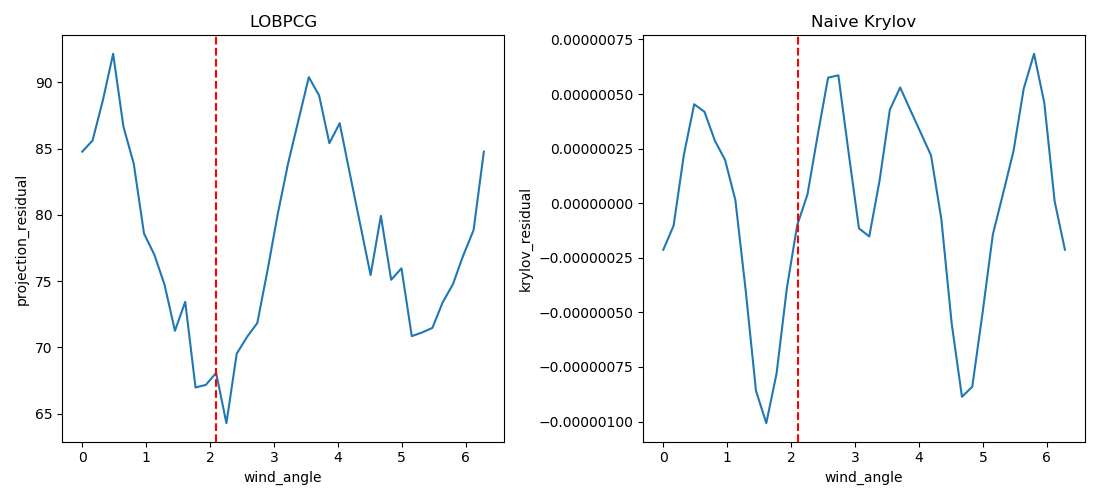

In [68]:
%matplotlib notebook 
degrees = [4, 8, 16, 24] 
fig, ax = plt.subplots(1, 2, figsize=(11,5))
(metrics.projection_residual).sel(deg=degrees).plot(ax=ax[0], hue='deg')
ax[0].axvline(wind_angle_true, linestyle='--', color='r')
ax[0].set_title('LOBPCG')

(metrics.krylov_residual - metrics.krylov_residual.mean('wind_angle')).sel(degree=degrees).plot(ax=ax[1], hue='degree')
ax[1].axvline(wind_angle_true, linestyle='--', color='r')
ax[1].set_title('Naive Krylov')
plt.tight_layout()

In [7]:
"""
Compute the full Rayleigh quotient for the full rank matrix
"""
coords = {info.dims[0]: info.data}
full_quotient = metric_utils.compute_full_quotient(humidity, hyperparams, coords)
full_quotient = xr.DataArray(full_quotient, dims=info.dims, coords=coords, name='full_quotient')
metrics = xr.merge([metrics, full_quotient])

Setting solver seed to: 15786

<IPython.core.display.Javascript object>


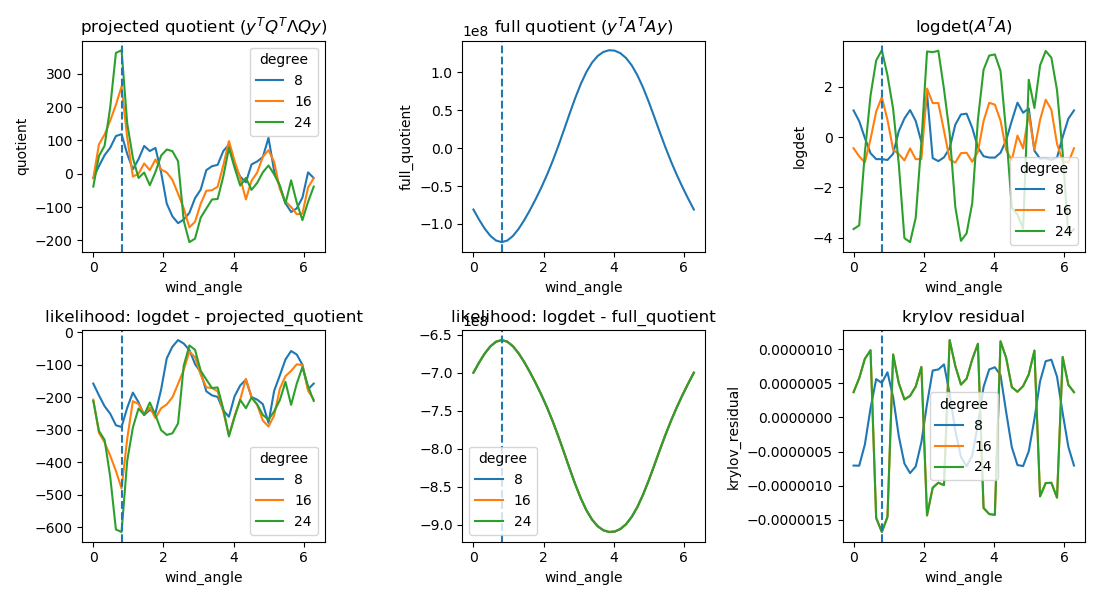

In [9]:
%matplotlib notebook

degrees = [8, 16, 24]
metrics_reduced = metrics.sel(degree=degrees)

fig, ax = plt.subplots(2, 3, figsize=(11,6))
(metrics_reduced.quotient - metrics_reduced.quotient.mean('wind_angle')).plot.line(ax=ax[0,0], hue='degree')
ax[0,0].set_title(r'projected quotient ($y^TQ^T \Lambda Q y$)')
ax[0,0].axvline(wind_angle_true, linestyle='--')

(metrics_reduced.full_quotient - metrics_reduced.full_quotient.mean('wind_angle')).plot.line(ax=ax[0,1])
ax[0,1].set_title(r'full quotient ($y^TA^T A y$)')
ax[0,1].axvline(wind_angle_true, linestyle='--')


(metrics_reduced.logdet - metrics_reduced.logdet.mean('wind_angle')).plot.line(ax=ax[0,2], hue='degree')
ax[0,2].set_title(r'$\log \det (A^TA)$')
ax[0,2].axvline(wind_angle_true, linestyle='--')

(metrics_reduced.logdet - metrics_reduced.quotient).plot.line(ax=ax[1,0], hue='degree')
ax[1,0].set_title('likelihood: logdet - projected_quotient')
ax[1,0].axvline(wind_angle_true, linestyle='--')


(metrics_reduced.logdet - metrics_reduced.full_quotient).plot.line(ax=ax[1,1], hue='degree')
ax[1,1].set_title('likelihood: logdet - full_quotient')
ax[1,1].axvline(wind_angle_true, linestyle='--')


(metrics_reduced.krylov_residual - metrics_reduced.krylov_residual.mean('wind_angle')).plot.line(ax=ax[1,2], hue='degree')
ax[1,2].set_title('krylov residual')
ax[1,2].axvline(wind_angle_true, linestyle='--')

plt.tight_layout()


## Full quotient confusion Matrix
---

In [101]:
hyperparams = {
    'nt': eigenvectors[0].nt.data,
    'nx': eigenvectors[0].nx.data,
    'ny': eigenvectors[0].ny.data,
    'wind_angle': 0.0,
    'wind_magnitude': eigenvectors[0].wind_magnitude.data,
    'correlation_time': eigenvectors[0].correlation_time.data,
    'correlation_length': eigenvectors[0].correlation_length.data,
    'evolution_length': eigenvectors[0].evolution_length.data,
    'spatial_angle': eigenvectors[0].spatial_angle.data,
    'tensor_ratio': eigenvectors[0].tensor_ratio.data}

confusion_matrix = []
for wind_angle in tqdm(info.data):
    hyperparams.update(wind_angle=wind_angle)
    solver = create_solver(**hyperparams)
    humidity = solver.run(num_frames=hyperparams['nt'], n_jobs=4, evolution_length=hyperparams['evolution_length'])
    full_quotient = compute_full_quotient(humidity, hyperparams, angles=info.data)
    confusion_matrix.append(xr.DataArray(
        full_quotient, dims='wind_angle', coords={'wind_angle': metrics.wind_angle}
    ).expand_dims(true_angle=[wind_angle]))
confusion_matrix = xr.concat(confusion_matrix, dim='true_angle')

Setting solver seed to: 20120


<IPython.core.display.Javascript object>


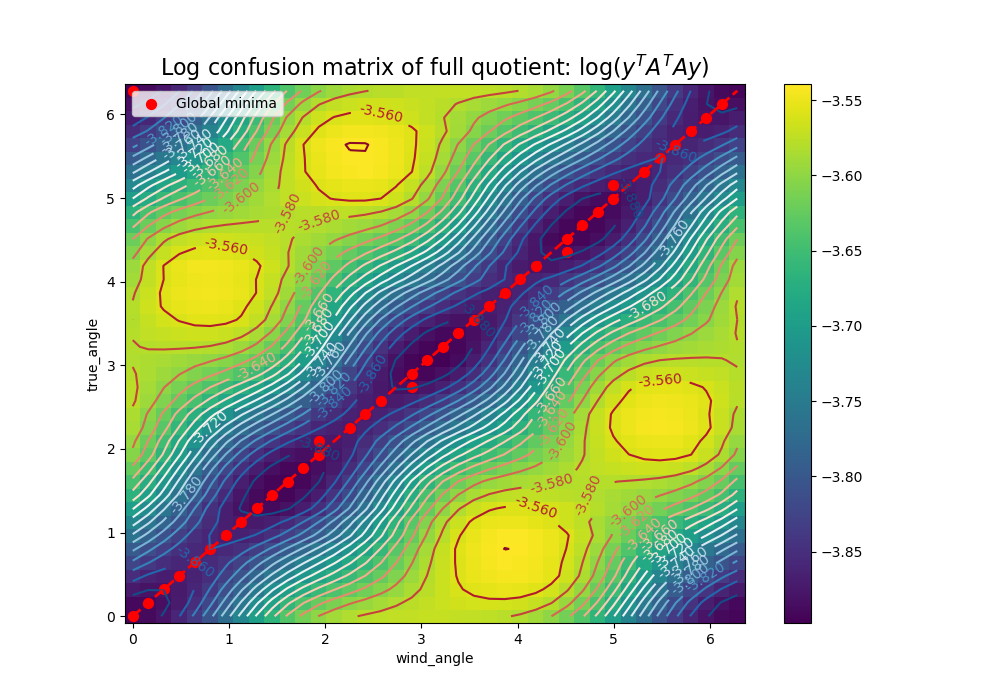

In [107]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10,7))
np.log(confusion_matrix / confusion_matrix.sum('wind_angle')).plot(ax=ax, add_labels=False)
cs = np.log(confusion_matrix / confusion_matrix.sum('wind_angle')).plot.contour(ax=ax, cmap='RdBu_r', levels=20)
ax.clabel(cs, inline=1, fontsize=10)
ax.set_title(r'Log confusion matrix of full quotient: $\log(y^T A^T A y)$', fontsize=16)
ax.plot(confusion_matrix.true_angle, confusion_matrix.true_angle, 'r--', linewidth=2)

# plot minimas
min_idx = confusion_matrix.argmin('wind_angle')
minima = confusion_matrix.wind_angle[min_idx]
ax.scatter(minima, confusion_matrix.true_angle, s=50, c='r', marker='o', label='Global minima')
plt.legend()

## Mode visualization
---

In [6]:
measurements = humidity.copy()
degrees = [4, 8, 16, 24]
projection_residual = xr.concat([metric_utils.projection_residual(
    measurements, eigenvectors, deg, return_projection=True) for deg in degrees], dim='deg')

<IPython.core.display.Javascript object>


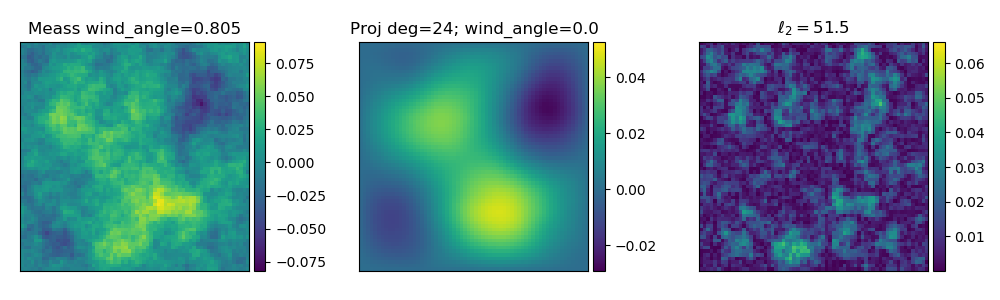

In [9]:
%matplotlib notebook
degree = 24
wind_angle = 0.0

data =  projection_residual.sel(deg=degree, wind_angle=wind_angle, method='nearest')
projection = data.projection
residual = data.projection_residual

movie_list = [measurements, projection, np.abs(measurements-projection)]
fig, axes = plt.subplots(1,3, figsize=(10, 3))
animation = pynoisy.utils.multiple_animations(
    movie_list, axes, titles=['Meass wind_angle={}'.format(wind_angle_true), 
                              'Proj deg={}; wind_angle={:1.3}'.format(projection.deg.data, projection.wind_angle.data),
                              r'$\ell_2={:2.3}$'.format(residual.data)]
)


<IPython.core.display.Javascript object>


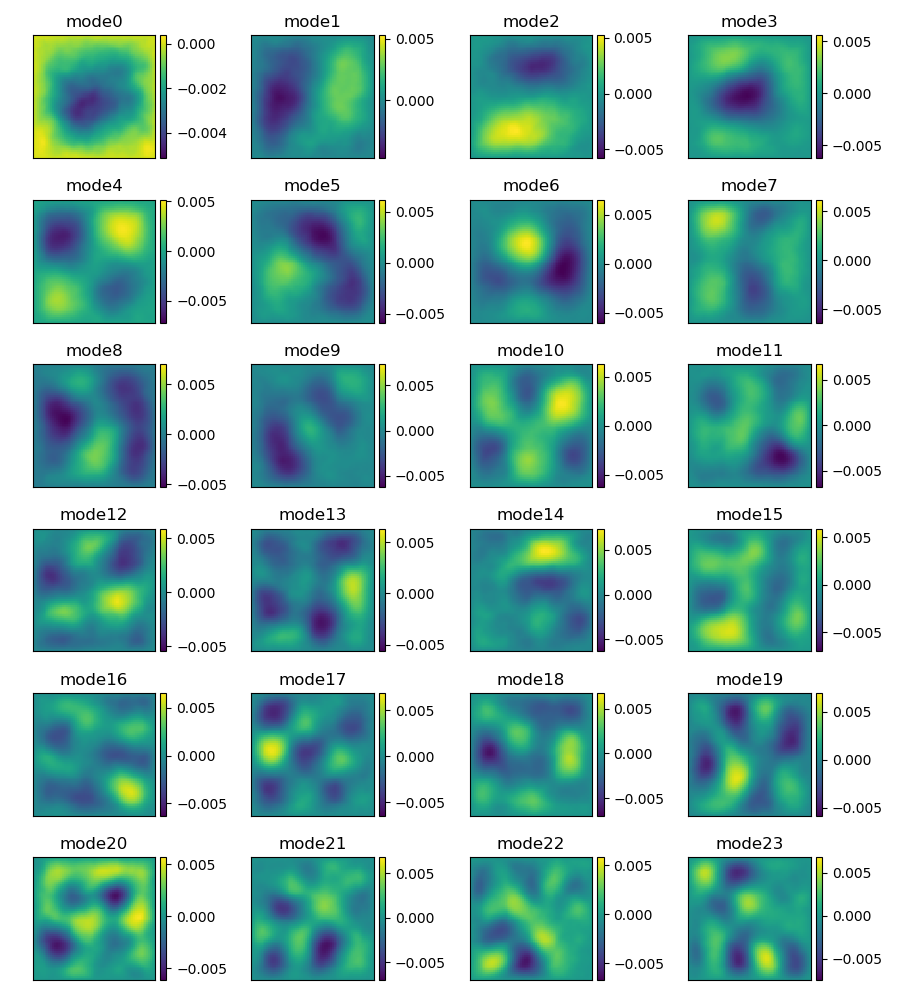

In [112]:
%matplotlib notebook
animation_degree = 24

wind_angle = wind_angle_true
fig, axes = plt.subplots(int(animation_degree/4),4, figsize=(9,10))
animation = pynoisy.utils.multiple_animations(
    modes_no_precond.eigenvectors.sel(deg=range(animation_degree), method='nearest'), 
    axes.ravel(), cmaps='viridis', titles=['mode{}'.format(deg) for deg in range(animation_degree)])